# 数据来源与分析目标

数据来源：https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering

分析目标：使用在线零售跨国数据集构建 RFM 聚类，并选择公司应该瞄准的最佳客户群。

# 导入库和数据

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

In [138]:
data = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [139]:
# 数据量
print(data.shape)

# 用户数
print('用户数量：', len(data['CustomerID'].unique()))

(541909, 8)
用户数量： 4373


In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [141]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


由此可知Quantity、UnitPrice	存在负数和异常值。

# 数据预处理

## 处理缺失值

In [142]:
# 检测缺失值
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]
if not missing_values.empty:
    print('数据集存在缺失值：')
    print(missing_values)
    print('\n缺失值比例：')
    print(missing_values/len(data))
else:
    print('数据集无缺失值。')

数据集存在缺失值：
Description      1454
CustomerID     135080
dtype: int64

缺失值比例：
Description    0.002683
CustomerID     0.249267
dtype: float64


In [143]:
# 删除缺失值
data = data.dropna()

# 再次确认是否存在缺失值
print(f'缺失值:\n{data.isnull().sum()}\n')

# 数据量
print(data.shape)

# 用户数
print('用户数量：', len(data['CustomerID'].unique()))

缺失值:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

(406829, 8)
用户数量： 4372


## 处理异常值

In [144]:
def remove_outliers_iqr(df, column):
    q3 = df[column].quantile(0.75)
    q1 = df[column].quantile(0.25)
    IQR = q3 - q1

    lower_bound = df[column] - 1.5 * IQR
    upper_bound = df[column] + 1.5 * IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [145]:
for col in ['Quantity', 'UnitPrice']:
    data = remove_outliers_iqr(data, col)

In [146]:
# 删除'Quantity'和'UnitPrice'中的负值
data = data[(data['Quantity'] >= 0) & (data['UnitPrice'] >= 0)]

# 检查是否存在负值
print((data['Quantity'] < 0).sum())
print((data['UnitPrice'] < 0).sum())

0
0


## 构建RMF特征

In [147]:
data['Amount'] = data['UnitPrice'] * data['Quantity']
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%d-%m-%Y %H:%M')
max_date = data['InvoiceDate'].max()
# today = pd.to_datetime('today').normalize()

rfm = data.groupby('CustomerID').agg(
    Recency = ('InvoiceDate', lambda x: (max_date - x.max()).days),
    Frequency = ('CustomerID', 'count'),
    Monetary = ('Amount', 'sum')
).reset_index()

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


In [148]:
RFM = rfm.copy()

# 分别对RFM分层，再根据聚类结果确定用户层级

In [149]:
from sklearn.cluster import KMeans

# 定义手肘图函数
def show_elbow(df):
    inertia = []
    for n in range(1,11):
        kmeans = KMeans(n_clusters =n, init='k-means++', n_init=10, max_iter=300, random_state=0)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(10,6))
    plt.plot(range(1,11), inertia)
    plt.xlabel('K的取值')
    plt.ylabel('损失')
    plt.title('K值手肘图');

## 根据Recency分层

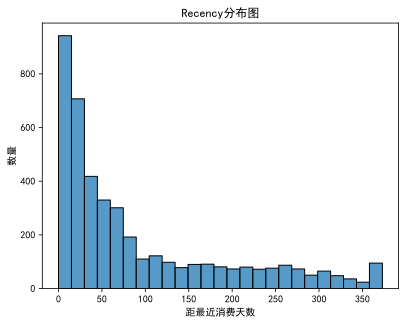

In [150]:
# 绘制Recency分布图
sns.histplot(rfm['Recency'])
plt.xlabel('距最近消费天数')
plt.ylabel('数量')
plt.title('Recency分布图');

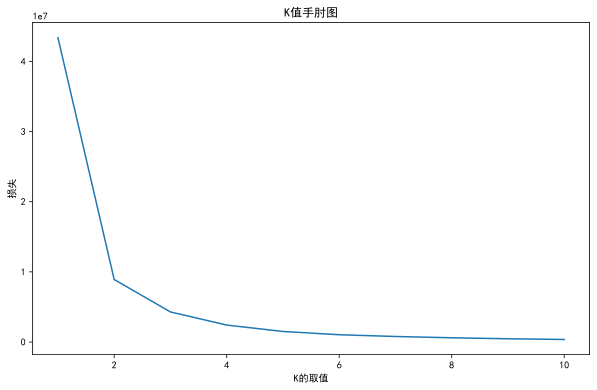

In [151]:
show_elbow(rfm[['Recency']])

In [152]:
# 对recency取K=4，重新训练kmeans模型
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(rfm[['Recency']])
rfm['R_cluster'] = kmeans.predict(rfm[['Recency']])
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_cluster
0,12346.0,325,1,77183.60,1
1,12347.0,1,182,4310.00,0
2,12348.0,74,31,1797.24,2
3,12349.0,18,73,1757.55,0
4,12350.0,309,17,334.40,1


## 根据Frequency分层

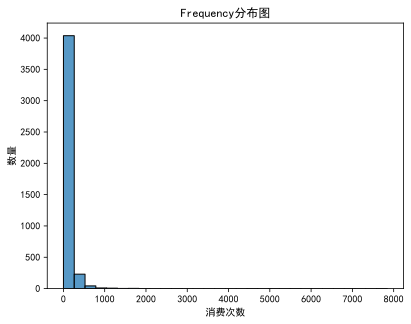

In [153]:
# 绘制Frequency分布图
sns.histplot(rfm['Frequency'], bins=30)
plt.xlabel('消费次数')
plt.ylabel('数量')
plt.title('Frequency分布图');

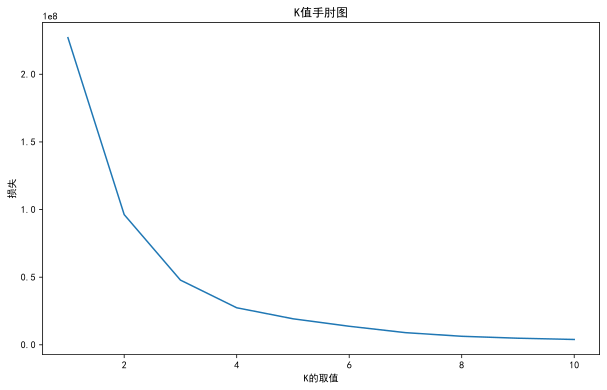

In [154]:
show_elbow(rfm[['Frequency']])

In [155]:
# 选择K=4，重新训练模型
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, random_state=0)
kmeans.fit(rfm[['Frequency']])
rfm['F_cluster'] = kmeans.predict(rfm[['Frequency']])
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_cluster,F_cluster
0,12346.0,325,1,77183.60,1,0
1,12347.0,1,182,4310.00,0,3
2,12348.0,74,31,1797.24,2,0
3,12349.0,18,73,1757.55,0,0
4,12350.0,309,17,334.40,1,0


## 根据Monetory分层

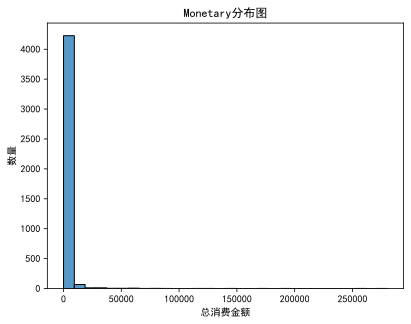

In [156]:
# 绘制Monetary分布图
sns.histplot(rfm['Monetary'], bins=30)
plt.xlabel('总消费金额')
plt.ylabel('数量')
plt.title('Monetary分布图');

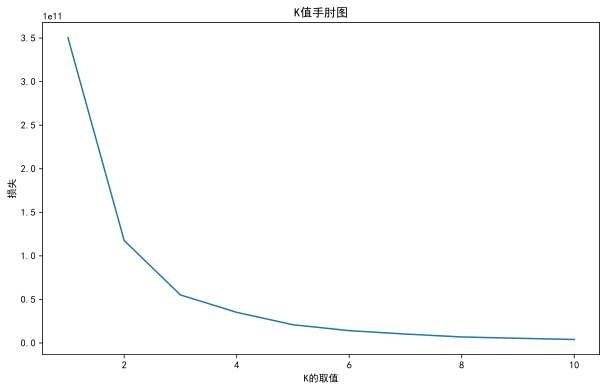

In [157]:
show_elbow(rfm[['Monetary']])

In [158]:
# 选择K=4，重新训练模型
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
kmeans.fit(rfm[['Monetary']])
rfm['M_cluster'] = kmeans.predict(rfm[['Monetary']])
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_cluster,F_cluster,M_cluster
0,12346.0,325,1,77183.60,1,0,2
1,12347.0,1,182,4310.00,0,3,0
2,12348.0,74,31,1797.24,2,0,0
3,12349.0,18,73,1757.55,0,0,0
4,12350.0,309,17,334.40,1,0,0


In [159]:
rfm.isnull().sum()

CustomerID    0
Recency       0
Frequency     0
Monetary      0
R_cluster     0
F_cluster     0
M_cluster     0
dtype: int64

## 对聚类结果重新排序

In [160]:
# 分别计算均值
df_r = rfm.groupby('R_cluster', as_index=False)['Recency'].mean().sort_values(by='Recency', ascending=False)  # 降序排列，R值越大，价值越小
df_f = rfm.groupby('F_cluster', as_index=False)['Frequency'].mean().sort_values(by='Frequency')  # 升序排列，F值越大，价值越大
df_m = rfm.groupby('M_cluster', as_index=False)['Monetary'].mean().sort_values(by='Monetary')  # 升序排列，M值越大，价值越大

# 重新编号
df_r['R_rank'] = range(len(df_r))
df_f['F_rank'] = range(len(df_f))
df_m['M_rank'] = range(len(df_m))

# 创建映射字典
r_mapping = dict(zip(df_r['R_cluster'], df_r['R_rank']))
f_mapping = dict(zip(df_f['F_cluster'], df_f['F_rank']))
m_mapping = dict(zip(df_m['M_cluster'], df_m['M_rank']))

# 应用到数据集
rfm['R_cluster'] = rfm['R_cluster'].map(r_mapping)
rfm['F_cluster'] = rfm['F_cluster'].map(f_mapping)
rfm['M_cluster'] = rfm['M_cluster'].map(m_mapping)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_cluster,F_cluster,M_cluster
0,12346.0,325,1,77183.60,0,0,1
1,12347.0,1,182,4310.00,3,1,0
2,12348.0,74,31,1797.24,2,0,0
3,12349.0,18,73,1757.55,3,0,0
4,12350.0,309,17,334.40,0,0,0


In [161]:
rfm['Score'] = rfm['R_cluster'] + rfm['F_cluster'] + rfm['M_cluster']
rfm['Score'] = rfm['Score']
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_cluster,F_cluster,M_cluster,Score
0,12346.0,325,1,77183.60,0,0,1,1
1,12347.0,1,182,4310.00,3,1,0,4
2,12348.0,74,31,1797.24,2,0,0,2
3,12349.0,18,73,1757.55,3,0,0,3
4,12350.0,309,17,334.40,0,0,0,0


In [162]:
rfm['Score'].value_counts().sort_values()

Score
9       2
7       5
8       5
6      19
5     152
0     486
1     577
4     622
2     916
3    1555
Name: count, dtype: int64

In [186]:
df_monetary = rfm.groupby('Score', as_index=False)['Monetary'].sum()
df_monetary['Count'] = rfm.groupby('Score')['CustomerID'].count()
df_monetary['Score'] = df_monetary['Score'].astype(int)
df_monetary['Average'] = (df_monetary['Monetary']/df_monetary['Count']).round(4)
df_monetary

,Score,Monetary,Count,Average
0,0,179120.330,486,368.5603
1,1,393977.120,577,682.8026
2,2,864548.883,916,943.8307
3,3,1802703.381,1555,1159.2948
4,4,2279921.670,622,3665.4689
5,5,1449386.160,152,9535.4353
6,6,676433.320,19,35601.7537
7,7,324372.940,5,64874.5880
8,8,516913.020,5,103382.6040
9,9,424031.080,2,212015.5400


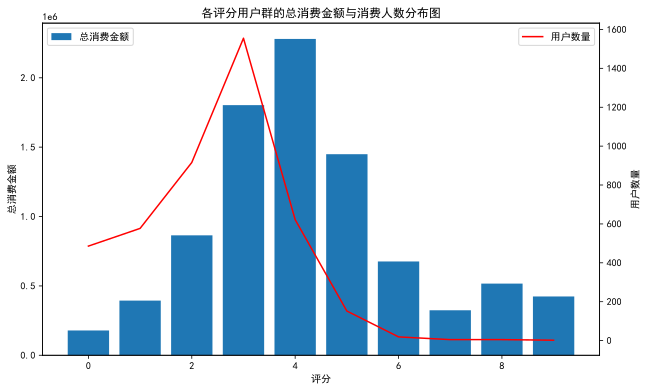

In [193]:
# 各评分用户群的总消费金额与消费人数分布图
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(df_monetary['Score'], df_monetary['Monetary'], label='总消费金额')
ax1.set_xlabel('评分')
ax1.set_ylabel('总消费金额')

ax2 = ax1.twinx()
ax2.plot(df_monetary['Score'], df_monetary['Count'], color='red', label='用户数量')
ax2.set_ylabel('用户数量')

ax1.legend(loc='upper left')
ax2.legend()
plt.title('各评分用户群的总消费金额与消费人数分布图');

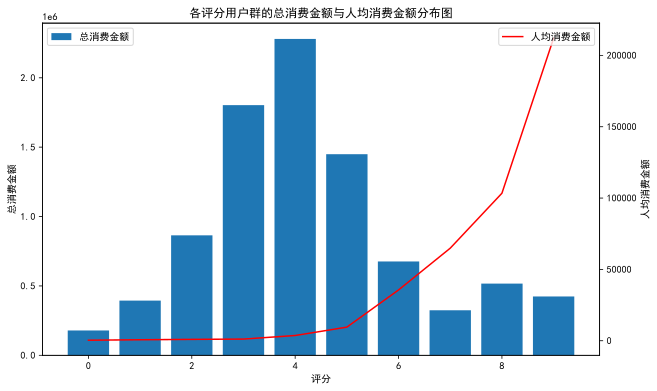

In [192]:
# 各评分用户群的总消费金额与人均消费金额分布图
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(df_monetary['Score'], df_monetary['Monetary'], label='总消费金额')
ax1.set_xlabel('评分')
ax1.set_ylabel('总消费金额')

ax2 = ax1.twinx()
ax2.plot(df_monetary['Score'], df_monetary['Average'], color='red', label='人均消费金额')
ax2.set_ylabel('人均消费金额')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('各评分用户群的总消费金额与人均消费金额分布图');

In [165]:
rfm.loc[(6 <= rfm['Score']), 'CustomerValue'] = '高价值用户'
rfm.loc[(2 <= rfm['Score']) & (rfm['Score'] < 6), 'CustomerValue'] = '中等价值用户'
rfm.loc[(rfm['Score'] < 2),'CustomerValue'] = '一般价值用户'
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_cluster,F_cluster,M_cluster,Score,CustomerValue
0,12346.0,325,1,77183.60,0,0,1,1,一般价值用户
1,12347.0,1,182,4310.00,3,1,0,4,中等价值用户
2,12348.0,74,31,1797.24,2,0,0,2,中等价值用户
3,12349.0,18,73,1757.55,3,0,0,3,中等价值用户
4,12350.0,309,17,334.40,0,0,0,0,一般价值用户


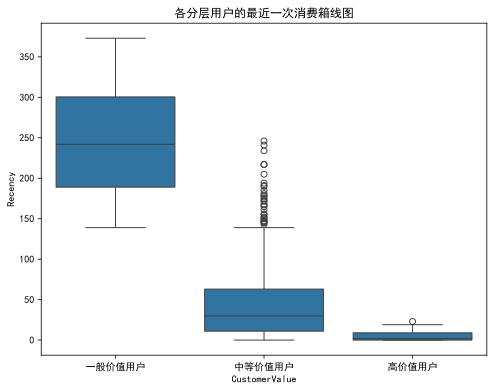

In [212]:
# 绘制各分层用户的最近一次消费箱线图
plt.figure(figsize=(8,6))
sns.boxplot(x=rfm['CustomerValue'], y=rfm['Recency'])
plt.title('各分层用户的最近一次消费箱线图');

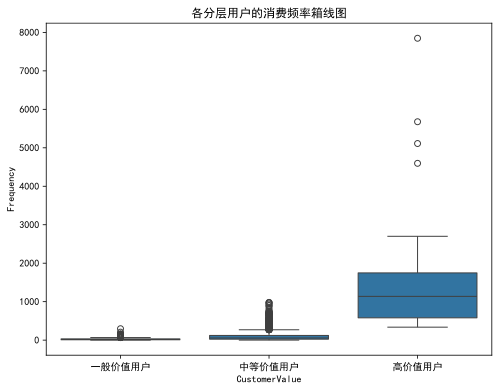

In [213]:
# 绘制各分层用户的消费频率箱线图
plt.figure(figsize=(8,6))
sns.boxplot(x=rfm['CustomerValue'], y=rfm['Frequency'])
plt.title('各分层用户的消费频率箱线图');

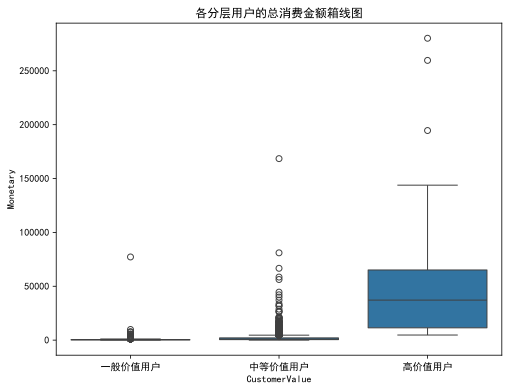

In [214]:
# 绘制各分层用户的总消费金额箱线图
plt.figure(figsize=(8,6))
sns.boxplot(x=rfm['CustomerValue'], y=rfm['Monetary'])
plt.title('各分层用户的总消费金额箱线图');

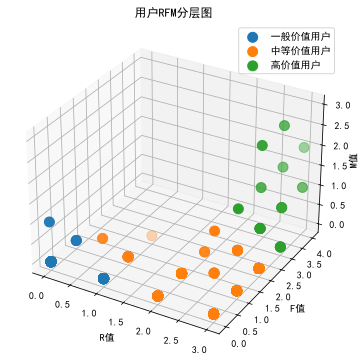

In [ ]:
# 绘制3D
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
for label in ['一般价值用户', '中等价值用户', '高价值用户']:
    ax.scatter(
        rfm.loc[rfm['CustomerValue'] == label]['R_cluster'],
        rfm.loc[rfm['CustomerValue'] == label]['F_cluster'],
        rfm.loc[rfm['CustomerValue'] == label]['M_cluster'],
        label=f'{label}',
        cmap='magma',
        s=100
    )
    ax.set_xlabel('R值')
    ax.set_ylabel('F值')
    ax.set_zlabel('M值', labelpad=-1, rotation=90)
    ax.legend()
    ax.set_title('用户RFM分层图');

# 将RFM作为聚类特征， 直接对用户分层

In [167]:
RFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


In [168]:
# 对数据标准化，减少量纲对模型的影响
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
RFM[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(RFM[['Recency', 'Frequency', 'Monetary']])

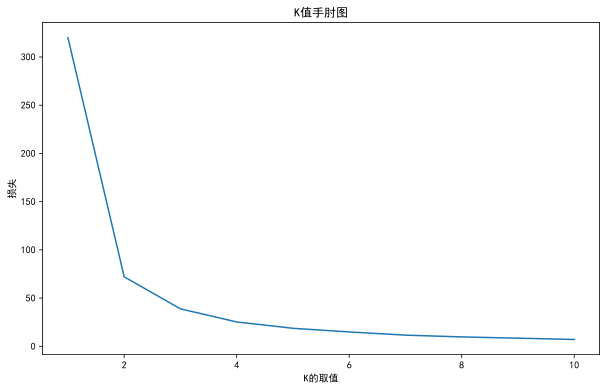

In [169]:
# 绘制手肘图
show_elbow(RFM[['Recency', 'Frequency', 'Monetary']])

In [170]:
# 计算轮廓系数
from sklearn.metrics import silhouette_score

for n in [3, 4, 5]:
    kmeans = KMeans(n_clusters=n, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(RFM[['Recency', 'Frequency', 'Monetary']])
    labels = kmeans.labels_

    sil_score = silhouette_score(RFM[['Recency', 'Frequency', 'Monetary']], labels)
    print(f'k={n}时，轮廓系数为{sil_score:.4f}')

k=3时，轮廓系数为0.6527
k=4时，轮廓系数为0.5774
k=5时，轮廓系数为0.5704


结合K手肘图和轮廓系数，选择K=3。

In [171]:
# 选择K=3，重新训练模型
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=0)
kmeans.fit(RFM[['Recency', 'Frequency', 'Monetary']])
centroids = kmeans.cluster_centers_
RFM['cluster'] = kmeans.predict(RFM[['Recency', 'Frequency', 'Monetary']])
RFM.head()

,CustomerID,Recency,Frequency,Monetary,cluster
0,12346.0,0.871314,0.000000,0.275453,2
1,12347.0,0.002681,0.023069,0.015382,1
2,12348.0,0.198391,0.003824,0.006414,1
3,12349.0,0.048257,0.009177,0.006272,1
4,12350.0,0.828418,0.002039,0.001193,2


In [172]:
# 计算每个簇的均值
cluster_mean = RFM.groupby('cluster',as_index=False)[['Recency', 'Frequency', 'Monetary']].mean()

# 按照Frequency对均值进行排序
cluster_mean['cluster_rank'] = cluster_mean['Frequency'].rank()

# 根据排序映射编号
cluster_mapping = dict(zip(cluster_mean['cluster'], cluster_mean['cluster_rank']))

# 应用到原数据
RFM['cluster'] = RFM['cluster'].map(cluster_mapping)

RFM['cluster'] = RFM['cluster'].astype(int)
RFM.head()

,CustomerID,Recency,Frequency,Monetary,cluster
0,12346.0,0.871314,0.000000,0.275453,1
1,12347.0,0.002681,0.023069,0.015382,3
2,12348.0,0.198391,0.003824,0.006414,3
3,12349.0,0.048257,0.009177,0.006272,3
4,12350.0,0.828418,0.002039,0.001193,1


In [197]:
monetary = RFM.groupby('cluster')['Monetary'].sum()
monetary

cluster
1     1.356518
2     2.292160
3    28.154379
Name: Monetary, dtype: float64

In [198]:
user_count = RFM.groupby('cluster', as_index=False)['CustomerID'].count().rename(columns={'CustomerID':'count'})
user_count['cluster'] = user_count['cluster'].astype(int)

user_count = user_count.merge(monetary, on='cluster')
user_count['average'] = (user_count['Monetary']/user_count['count']).round(4)
user_count

,cluster,count,Monetary,average
0,1,626,1.356518,0.0022
1,2,806,2.292160,0.0028
2,3,2907,28.154379,0.0097


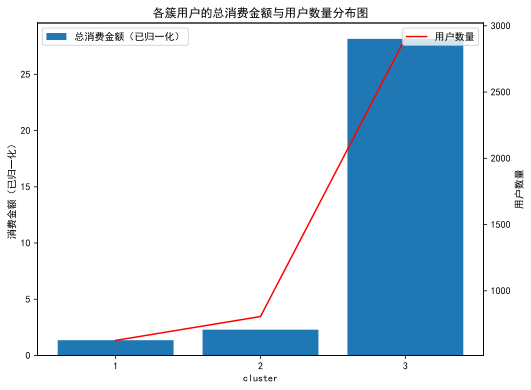

In [206]:
# 各簇用户的总消费金额与用户数量分布图
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.bar(user_count['cluster'], user_count['Monetary'], label='总消费金额（已归一化）')
ax1.set_xticks(user_count['cluster'].astype(int))  # 确保 x 轴刻度是整数
ax1.set_xlabel('cluster')
ax1.set_ylabel('消费金额（已归一化）')

ax2 = ax1.twinx()
ax2.plot(user_count['cluster'], user_count['count'], color='red', label='用户数量')
ax2.set_ylabel('用户数量')

ax1.legend()
ax2.legend(loc='upper right')
plt.title('各簇用户的总消费金额与用户数量分布图');

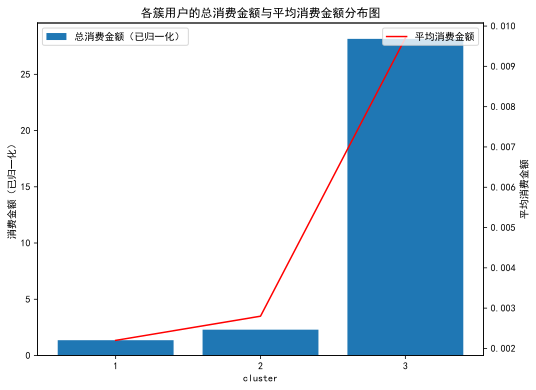

In [201]:
# 各簇用户的总消费金额与平均消费金额分布图
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.bar(user_count['cluster'], user_count['Monetary'], label='总消费金额（已归一化）')
ax1.set_xticks(user_count['cluster'].astype(int))  # 确保 x 轴刻度是整数
ax1.set_xlabel('cluster')
ax1.set_ylabel('消费金额（已归一化）')

ax2 = ax1.twinx()
ax2.plot(user_count['cluster'], user_count['average'], color='red', label='平均消费金额')
ax2.set_ylabel('平均消费金额')

ax1.legend()
ax2.legend(loc='upper right')
plt.title('各簇用户的总消费金额与平均消费金额分布图');

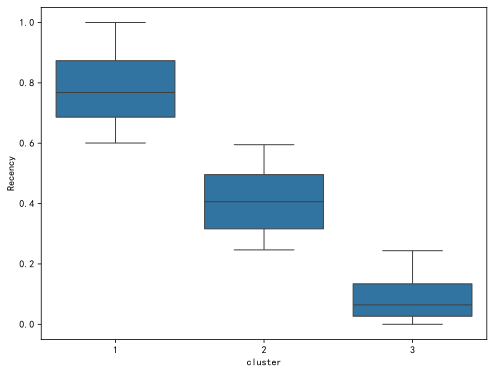

In [204]:
plt.figure(figsize=(8,6))
sns.boxplot(x=RFM['cluster'], y=RFM['Recency'])
plt.xlabel('cluster')
plt.ylabel('Recency');

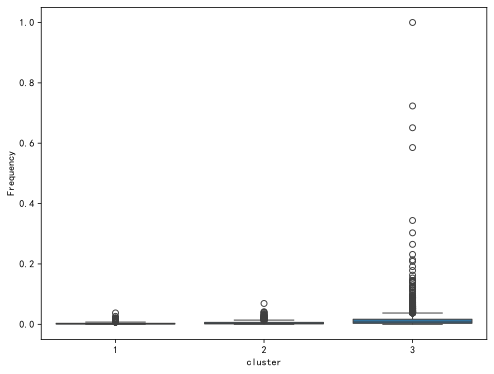

In [205]:
# 绘制RFM箱线图
plt.figure(figsize=(8,6))
sns.boxplot(x=RFM['cluster'], y=RFM['Frequency'])
plt.xlabel('cluster')
plt.ylabel('Frequency');

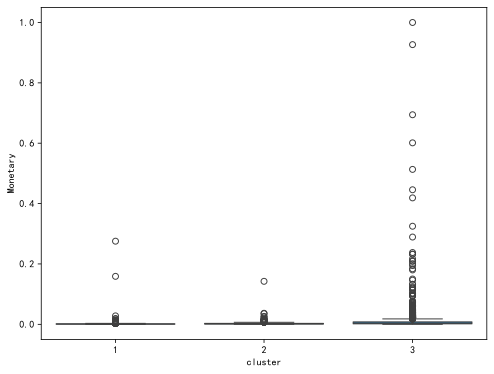

In [203]:
plt.figure(figsize=(8,6))
sns.boxplot(x=RFM['cluster'], y=RFM['Monetary'])
plt.xlabel('cluster')
plt.ylabel('Monetary');

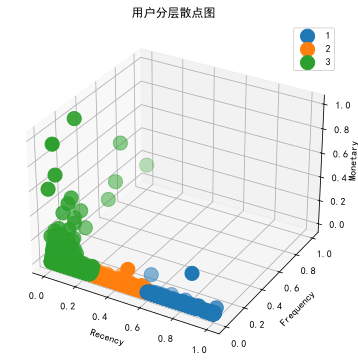

In [180]:
# 绘制3D散点图
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
for label in [1,2,3]:
    ax.scatter(
        RFM.loc[RFM['cluster'] == label]['Recency'],
        RFM.loc[RFM['cluster'] == label]['Frequency'],
        RFM.loc[RFM['cluster'] == label]['Monetary'],
        label=f'{label}',
        cmap='magma',
        s=200
    )
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary', labelpad=-1, rotation=90)
    ax.legend()
    ax.set_title('用户分层散点图');

# 总结

本次使用两种方法进行用户细分：
- 方法一：分别使用KMeans聚类算法划分RFM三个变量，最后再将各自的结果综合考虑。在此划分中，中等价值用户的数量最多，总消费金额也最多，是该公司的主要客户群体，但是高价值用户的人均消费金额远远高于中等价值用户，需重点关注。（方法一也可以使用分位数法划分数据，更加通俗易懂。）

- 方法二：对RFM三个特征先进行归一化处理，再使用KMeans聚类算法用户群。在此划分中，簇3的用户数量、总体消费金额、平均消费金额是最多的，是该公司的最佳客户群体。

方法一中的高价值用户和中等价值用户的数量之和与方法二中的簇3的用户数量基本相当，都能作为公司的最佳客户群体。其中方法一对用户的划分更加细致，在应用中可结合实际业务情况选取合适的划分界限。